### Import necessary libraries

List of Required External Libraries

1. Scikit Learn
2. torch
3. torchmetrics
4. OpenCV
5. PIL
6. torchvision
7. Numpy
8. Pandas


In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchvision import transforms
import torchvision.models as models
from PIL import Image




for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample6444.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample7902.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample2868.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample49.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample5106.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample134.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample3918.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample977.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample3530.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample5995.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample5315.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample355.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample7617.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample7236.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample8176.npy
/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR/sample8606.n

### Setting Seed for Reproducibility of Results

In [2]:
seed = 1234

random.seed(seed)  # Python's built-in random module
np.random.seed(seed)  # NumPy
torch.manual_seed(seed)  # PyTorch CPU
torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
torch.cuda.manual_seed_all(seed)  # All GPUs (if using multi-GPU)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disabling can reduce performance but ensures reproducibility


### Identifying the device (CUDA / CPU)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
calc_psnr = torchmetrics.image.PeakSignalNoiseRatio().to(device)
calc_ssim = torchmetrics.image.StructuralSimilarityIndexMeasure().to(device)

### To re-run the notebook plese use the path where the data is stored

In [5]:
HR_img_dir = '/kaggle/input/gsoc25-sr-task-3a-data/Dataset/HR'
LR_img_dir = '/kaggle/input/gsoc25-sr-task-3a-data/Dataset/LR'

### Creating Dataloaders for High and Low Resolution Images

In [6]:
def load_hr_lr_npy_to_dataframe(hr_dir, lr_dir):
    data = []
    
    hr_files = {file: os.path.join(hr_dir, file) for file in os.listdir(hr_dir) if file.endswith('.npy')}
    lr_files = {file: os.path.join(lr_dir, file) for file in os.listdir(lr_dir) if file.endswith('.npy')}
    
    common_files = set(hr_files.keys()) & set(lr_files.keys())
    
    for file in common_files:
        data.append({'HR_image': hr_files[file], 'LR_image': lr_files[file]})
    
    return pd.DataFrame(data)

common_df = load_hr_lr_npy_to_dataframe(HR_img_dir, LR_img_dir)
common_df.shape

(10000, 2)

In [7]:
np.load(common_df.iloc[0]["HR_image"]).shape, np.load(common_df.iloc[0]["LR_image"]).shape

((1, 150, 150), (1, 75, 75))

In [8]:
train_df, test_df = train_test_split(common_df, test_size=0.1, random_state=42, shuffle=True)
train_df.shape, test_df.shape

((9000, 2), (1000, 2))

In [9]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, shuffle=True)
train_df.shape, val_df.shape

((8100, 2), (900, 2))

### Displaying Some Images for Vizualization Purpose

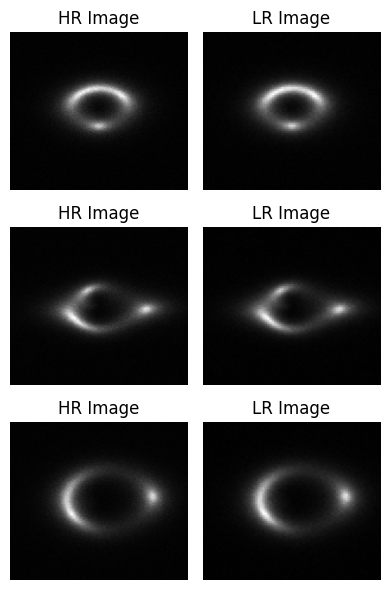

In [10]:
def display_images_grid(df, num_images=2):
    fig, axes = plt.subplots(num_images, 2, figsize=(4, 6))
    
    for i in range(num_images):
        hr_image = np.load(df.iloc[i]["HR_image"]).reshape(150, 150)
        lr_image = np.load(df.iloc[i]["LR_image"]).reshape(75, 75)
        
        axes[i, 0].imshow(hr_image, cmap='gray', aspect='auto')
        axes[i, 0].set_title("HR Image")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(lr_image, cmap='gray', aspect='auto')
        axes[i, 1].set_title("LR Image")
        axes[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Display first 5 images
display_images_grid(common_df, num_images=3)

### Dataset Class

In [11]:
class GravLenseImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        hr_image = np.squeeze(np.load(self.dataframe.iloc[idx]["HR_image"]).astype(np.float32))
        lr_image = np.squeeze(np.load(self.dataframe.iloc[idx]["LR_image"]).astype(np.float32))
       
        hr_image = torch.tensor(hr_image).unsqueeze(0)
        lr_image = torch.tensor(lr_image).unsqueeze(0)


        return hr_image, lr_image

In [12]:
train_dataset = GravLenseImageDataset(train_df)
test_dataset = GravLenseImageDataset(test_df)
val_dataset = GravLenseImageDataset(val_df)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=80, shuffle=True, drop_last=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=80, shuffle=False, drop_last=False, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=80, shuffle=False, drop_last=False, num_workers=2)

### Model Defination

In [14]:
class ResConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, padding, stride, act="lrlu"):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=kernel, padding=padding, stride=stride)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=kernel, padding=padding, stride=stride)
        
        self.res = nn.Conv2d(in_ch, out_ch, kernel_size=1)
        
        self.lrlu = nn.LeakyReLU(0.05, inplace=True)
        self.act = act

    def forward(self, x):
        skip = self.res(x)
        conv1 = self.lrlu(self.conv1(x))
        conv2 = self.conv2(conv1)

        if self.act == "lrlu":
            return self.lrlu(conv2 + skip)

        return conv2 + skip
        

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.resconv1 = ResConv(1, 128, kernel=3, padding=1, act="lrlu", stride=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=2)
        self.out_conv = nn.Conv2d(32, 1, kernel_size=3, padding=1, stride=1)
        
        self.lrlu = nn.LeakyReLU(0.05, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.resconv1(x)
        x = self.pixel_shuffle(x)
        x = self.out_conv(x)
        return self.sigmoid(x)


In [16]:
generator = Generator().to(device)

In [17]:
generator(torch.randn(2, 1, 75, 75).float().cuda()).shape

torch.Size([2, 1, 150, 150])

In [18]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1),
            nn.LeakyReLU(0.05, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.LeakyReLU(0.05, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.LeakyReLU(0.05, inplace=True),

            nn.Conv2d(256, 256, kernel_size=4, stride=2),
            nn.LeakyReLU(0.05, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2),
            nn.LeakyReLU(0.05, inplace=True),

            nn.Conv2d(512, 512, kernel_size=4, stride=2),
            nn.LeakyReLU(0.05, inplace=True),
        )
        self.mlp = nn.Linear(2048, 1)

    def forward(self, x):
        features = self.critic(x)
        return self.mlp(features.flatten(start_dim=1))


In [19]:
critic = Critic().to(device)

In [20]:
critic(torch.randn(5, 1, 150, 150).float().cuda()).shape

torch.Size([5, 1])

#### Initialize the model weights

In [21]:
def initialize_weights(model):
    # Initializes weights according to the WGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [22]:
generator.apply(initialize_weights)
critic.apply(initialize_weights)

Critic(
  (critic): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.05, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.05, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.05, inplace=True)
    (6): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0.05, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
    (9): LeakyReLU(negative_slope=0.05, inplace=True)
    (10): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2))
    (11): LeakyReLU(negative_slope=0.05, inplace=True)
  )
  (mlp): Linear(in_features=2048, out_features=1, bias=True)
)

In [23]:
torch.cuda.device_count()

2

### Use multiple GPUs if Available
##### The models (Generator & Critic) were trained on 2 T4 GPU

In [24]:
if torch.cuda.device_count() > 1:
    generator = nn.DataParallel(generator)  
    critic = nn.DataParallel(critic)

In [25]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


In [26]:
CRITIC_ITR = 5
LAMBDA = 8
ALPHA = 0.4
EPOCHS = 6

In [27]:
optim_gen = torch.optim.Adam(generator.parameters(), lr=3e-4, betas=(0.9, 0.99))
optim_critic = torch.optim.Adam(critic.parameters(), lr=4e-4, betas=(0.0, 0.9))

In [28]:
from tqdm import tqdm

In [29]:
class VGGFeatureExtractor(torch.nn.Module):
    def __init__(self, layers=[2, 7, 12]):  # Use layers from early, mid, and deep parts of VGG
        super(VGGFeatureExtractor, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        self.vgg_layers = torch.nn.ModuleList([vgg[:l] for l in layers])
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, img):
        features = [layer(img) for layer in self.vgg_layers]
        return features

if torch.cuda.device_count() > 1:
    vgg_extractor = nn.DataParallel(VGGFeatureExtractor().to(device))  # This will wrap it for multiple GPUs

def perceptual_loss(gen_img, hr_img):
    vgg_extractor.eval()
    gen_features = vgg_extractor(gen_img)
    hr_features = vgg_extractor(hr_img)
    loss = sum(F.mse_loss(g, h) for g, h in zip(gen_features, hr_features))
    return loss


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 227MB/s] 


In [30]:
def val():
    generator.eval()
    critic.eval()
    batches = len(val_dataloader)

    gen_loss = 0
    cri_loss = 0
    wasserstein_distance = 0
    mse_loss = 0
    psnr = 0
    ssim = 0

    for i, batch in enumerate(val_dataloader):
        hr_images, lr_images = batch
        lr_images = lr_images.to(device).float()
        hr_images = hr_images.to(device).float()


        gen_hr_image = generator(lr_images)

        gen_score = critic(gen_hr_image.detach()).mean()
        actual_score = critic(hr_images).mean()

        wasserstein_distance = actual_score - gen_score
        gp = gradient_penalty(critic, hr_images, gen_hr_image, device=device)
        critic_loss = -wasserstein_distance + LAMBDA * gp

        mse = F.mse_loss(gen_hr_image, hr_images)

            
        generator_loss = -0.07*gen_score + 0.1*mse

        gen_loss += generator_loss.item()
        cri_loss += critic_loss.item()
        wasserstein_distance += wasserstein_distance.item()
        mse_loss += mse.item()

        calc_psnr.update(gen_hr_image, hr_images)
        calc_ssim.update(gen_hr_image, hr_images)

    print(f"Validation")
    print(f"Gen Loss: {(gen_loss/batches):.4f} | Cri Loss: {(cri_loss/batches):.4f} | PSNR: {(calc_psnr.compute().cpu()):.4f} | SSIM: {(calc_ssim.compute().cpu()):.4f} | MSE: {(mse_loss/batches):.4f}\n")
    calc_psnr.reset()
    calc_ssim.reset()



In [31]:
def test():
    generator.eval()
    critic.eval()
    batches = len(test_dataloader)

    gen_loss = 0
    cri_loss = 0
    wasserstein_distance = 0
    mse_loss = 0
    psnr = 0
    ssim = 0

    for i, batch in enumerate(test_dataloader):
        hr_images, lr_images = batch
        lr_images = lr_images.to(device).float()
        hr_images = hr_images.to(device).float()


        gen_hr_image = generator(lr_images)

        gen_score = critic(gen_hr_image.detach()).mean()
        actual_score = critic(hr_images).mean()

        wasserstein_distance = actual_score - gen_score
        gp = gradient_penalty(critic, hr_images, gen_hr_image, device=device)
        critic_loss = -wasserstein_distance + LAMBDA * gp

        mse = F.mse_loss(gen_hr_image, hr_images)
            
        generator_loss = -0.07*gen_score + 0.1*mse 

        gen_loss += generator_loss.item()
        cri_loss += critic_loss.item()
        wasserstein_distance += wasserstein_distance.item()
        mse_loss += mse.item()

        calc_psnr.update(gen_hr_image, hr_images)
        calc_ssim.update(gen_hr_image, hr_images)


    print(f"Gen Loss: {(gen_loss/batches):.4f} | Cri Loss: {(cri_loss/batches):.4f} | PSNR: {(calc_psnr.compute().cpu()):.4f} | SSIM: {(calc_ssim.compute().cpu()):.4f} | MSE: {(mse_loss/batches):.4f}\n")
    calc_psnr.reset()
    calc_ssim.reset()



In [32]:
def train():
    generator.train()
    critic.train()
    batches = len(train_dataloader)
    for epoch in range(EPOCHS):
        progress_bar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{EPOCHS}]", leave=True)

        gen_loss = 0
        cri_loss = 0
        wasserstein_distance = 0
        mse_loss = 0
        psnr = 0
        ssim = 0
        for i, batch in enumerate(progress_bar):
            hr_images, lr_images = batch
            lr_images = lr_images.to(device).float()
            hr_images = hr_images.to(device).float()

            generator.eval()
            critic.train()

            for _ in range(CRITIC_ITR):
                
                fake = generator(lr_images)

                real_score = critic(hr_images)
                fake_score = critic(fake.detach())

                gp = gradient_penalty(critic, hr_images, fake, device=device)

                wasserstein_distance = real_score.mean() - fake_score.mean()

                critic_loss = -wasserstein_distance + LAMBDA * gp

                optim_critic.zero_grad()
                critic_loss.backward()
                optim_critic.step()

            generator.train()
            critic.eval()

            gen_hr_image = generator(lr_images)
                
            
            gen_score = critic(gen_hr_image.detach()).mean()
            actual_score = critic(hr_images).mean()

            wasserstein_distance = actual_score - gen_score
            gp = gradient_penalty(critic, hr_images, gen_hr_image, device=device)
            critic_loss = -wasserstein_distance + LAMBDA * gp

            mse = F.mse_loss(gen_hr_image, hr_images)

            generator_loss = -0.07*gen_score + 0.1*mse


            gen_loss += generator_loss.item()
            cri_loss += critic_loss.item()
            wasserstein_distance += wasserstein_distance.item()
            mse_loss += mse.item()

            calc_psnr.update(gen_hr_image, hr_images)
            calc_ssim.update(gen_hr_image, hr_images)

            optim_gen.zero_grad()
            generator_loss.backward()
            optim_gen.step()

        progress_bar.set_postfix(D_loss=critic_loss.item(), G_loss=generator_loss.item(), PSNR=calc_psnr.compute().cpu(), SSIM=calc_ssim.compute().cpu(), MSE=mse_loss/batches)

        print(f"Training")
        print(f"Gen Loss: {(gen_loss/batches):.4f} | Cri Loss: {(cri_loss/batches):.4f} | PSNR: {(calc_psnr.compute().cpu()):.4f} | SSIM: {(calc_ssim.compute().cpu()):.4f} | MSE: {(mse_loss/batches):.4f}\n")
        calc_psnr.reset()
        calc_ssim.reset()
        progress_bar.close()

        val()



In [33]:
train()

Epoch [1/6]: 100%|██████████| 101/101 [11:02<00:00,  6.56s/it]


Training
Gen Loss: 30.7041 | Cri Loss: -27.4029 | PSNR: 14.1896 | SSIM: 0.3659 | MSE: 0.0381

Validation
Gen Loss: 21.4927 | Cri Loss: -8.6739 | PSNR: 22.7455 | SSIM: 0.5477 | MSE: 0.0053



Epoch [2/6]: 100%|██████████| 101/101 [11:13<00:00,  6.67s/it]


Training
Gen Loss: 21.8668 | Cri Loss: -3.7441 | PSNR: 27.4485 | SSIM: 0.7094 | MSE: 0.0018

Validation
Gen Loss: 3.4546 | Cri Loss: -2.9632 | PSNR: 29.7403 | SSIM: 0.7921 | MSE: 0.0011



Epoch [3/6]: 100%|██████████| 101/101 [11:17<00:00,  6.71s/it]


Training
Gen Loss: 6.0370 | Cri Loss: -2.4477 | PSNR: 30.6631 | SSIM: 0.8205 | MSE: 0.0009

Validation
Gen Loss: 25.4087 | Cri Loss: -2.3055 | PSNR: 31.6398 | SSIM: 0.8447 | MSE: 0.0007



Epoch [4/6]: 100%|██████████| 101/101 [11:18<00:00,  6.72s/it]


Training
Gen Loss: 14.5520 | Cri Loss: -2.0116 | PSNR: 32.4529 | SSIM: 0.8621 | MSE: 0.0006

Validation
Gen Loss: 56.1511 | Cri Loss: -2.0131 | PSNR: 33.2588 | SSIM: 0.8774 | MSE: 0.0005



Epoch [5/6]: 100%|██████████| 101/101 [11:18<00:00,  6.71s/it]


Training
Gen Loss: -1.0879 | Cri Loss: -1.5545 | PSNR: 33.9454 | SSIM: 0.8875 | MSE: 0.0004

Validation
Gen Loss: 57.3531 | Cri Loss: -1.5325 | PSNR: 34.6823 | SSIM: 0.8970 | MSE: 0.0003



Epoch [6/6]: 100%|██████████| 101/101 [11:17<00:00,  6.71s/it]


Training
Gen Loss: -21.4618 | Cri Loss: -1.3973 | PSNR: 35.4026 | SSIM: 0.9050 | MSE: 0.0003

Validation
Gen Loss: -20.7931 | Cri Loss: -0.4475 | PSNR: 36.1937 | SSIM: 0.9132 | MSE: 0.0002



In [37]:
test()

Gen Loss: -20.7949 | Cri Loss: -0.4496 | PSNR: 36.2030 | SSIM: 0.9133 | MSE: 0.0002



In [39]:
torch.save(generator, "gsoc25_sr_task1_generator_model_FINAL.pth")
torch.save(critic, "gsoc25_sr_task1_critic_model_FINAL.pth")

### Vizualizing the Super Resolved Images

SR Image : torch.Size([2, 150, 150])


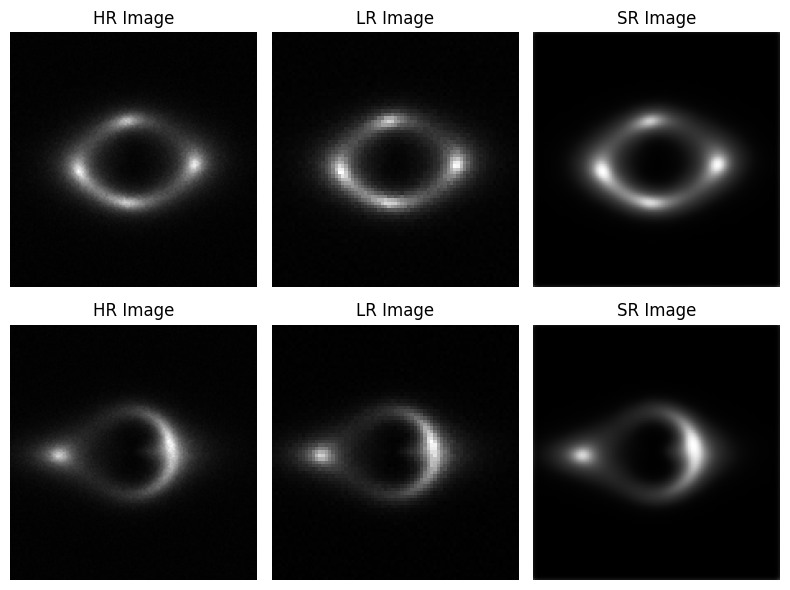

In [38]:
def plot():
    fig, axes = plt.subplots(2, 3, figsize=(8, 6))
    
    generator.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            hr_images, lr_images = batch
            lr_image = lr_images.to(device)[12:14].float()
            hr_image = hr_images.to(device)[12:14].float()
        
        
            sr_image = generator(lr_image).cpu().squeeze(1)
            print(f"SR Image : {sr_image.shape}")
            break
        
        
    for i in range(2):
        axes[i, 0].imshow(hr_image[i].cpu().numpy().reshape(150, 150), cmap='gray', aspect='auto')
        axes[i, 0].set_title("HR Image")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(lr_image[i].cpu().numpy().reshape(75,75), cmap='gray', aspect='auto')
        axes[i, 1].set_title("LR Image")
        axes[i, 1].axis("off")
            
        axes[i, 2].imshow(sr_image[i].numpy().reshape(150,150), cmap='gray', aspect='auto')
        axes[i, 2].set_title("SR Image")
        axes[i, 2].axis("off")
        
    plt.tight_layout()
    plt.show()

plot()